<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-Filtering" data-toc-modified-id="Data-Filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Filtering</a></span></li><li><span><a href="#Resilience-Index" data-toc-modified-id="Resilience-Index-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Resilience Index</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Resilience-index-by-subcomponent" data-toc-modified-id="Resilience-index-by-subcomponent-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Resilience index by subcomponent</a></span></li><li><span><a href="#Updated-Social-Resiliency-Index" data-toc-modified-id="Updated-Social-Resiliency-Index-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Updated Social Resiliency Index</a></span></li></ul></li></ul></div>

# Background

In the study by Cutter et al. [Disaster Resilience Indicators for Benchmarking Baseline Conditions](Cutter_jhsem.2010.7.1.1732.pdf), the investigators provided a case study to _"illustrate the scalability of the resilence metric and to articulate the significance of a component-based approach for objective measurement"_.

In this notebook, we attempt to recreate their case study to exercise:

1. our understanding of their methodology using our datasets
1. scientific reproducibility

Cutter et al. selected 13 counties from 3 metropolitan statistical areas because they were _"highly diverse in terms of population, income, racial and ethnic identity, and age"_. In particular, they chose these 3 metropolitan areas _"since they are primary test beds of the Community and Regional Resilience Institute (CARRI)"_:

1. Gulfport-Biloxi, Mississippi
1. Charleston-North Charleston, South Carolina
1. Memphis, Tennessee

Below we display Table 3 from the Cutter et al. study which shows the 13 counties included in the case study, their composite scores for each of the disaster resilience components (social, economic, institutional, infrastructure, community capital), the aggregate resilience scores (sum of components scores), and the average resilience score for each metropolitan area (mean of the aggregate resilience score for each county in each metropolitan area):

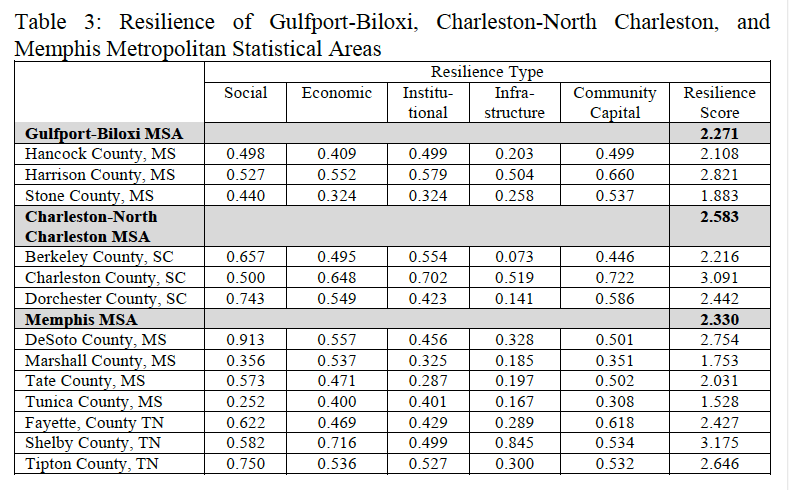

Below we display Figure 4 from the study to show the spatial distribution of the 13 counties in the 3 metropolitan areas:

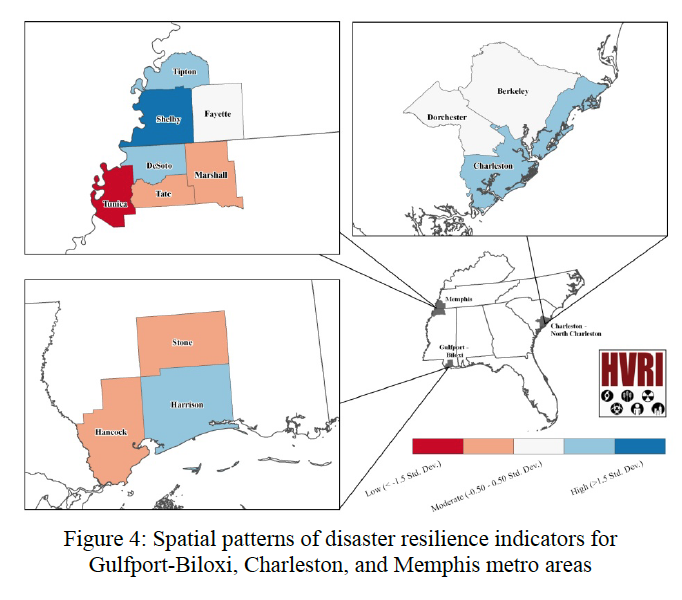

# Data Filtering

To recreate the above analysis, we must first filter down to the 13 counties used. The study did not give the FIPS codes for each county so we must perform a manual exercise of extracting those FIPS codes. Let's try to do that using code.

First let's setup our environment:

In [1]:
import os, sys, re, json, time
import matplotlib
from copy import deepcopy
from subprocess import check_output
import netCDF4 as NC
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, Choropleth
from ipywidgets import Layout, link, FloatSlider, Label, VBox
from astropy.time import Time
from IPython.display import display, HTML, Markdown
from branca.colormap import linear, LinearColormap
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, mapping
import geojson
import seaborn as sns

sns.set_style('white')

%matplotlib inline

and read in the US county shapefile:

In [2]:
def get_us_multipolygon():
    """Return multipolygon of US counties."""
    
    counties_shp = os.path.join("geo_data", "counties", "cb_2017_us_county_500k.shp")
    us = gpd.read_file(counties_shp)
    us = us.to_crs(epsg=4326) # reproject to -180, 180
    return us
    
# get geopandas data frame of US county polygons
us_polys = get_us_multipolygon()

Let's remind ourselves of how this dataset looks like:

In [3]:
display(us_polys.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


We note that the `NAME` field contains the name of the county. Perhaps we can filter down to the 13 counties by matching on this field. Let's first create a list of the 13 county names by eyeballing them from table 3 above:

In [4]:
county_names = [
    'Hancock',
    'Harrison',
    'Stone',
    'Berkeley',
    'Charleston',
    'Dorchester',
    'DeSoto',
    'Marshall',
    'Tate',
    'Tunica',
    'Fayette',
    'Shelby',
    'Tipton'
]

Because we cannot assume county name uniqeness, let's see how many matches we get for each county name:

In [5]:
for cn in county_names:
    # match county name verbatim
    matches = us_polys[us_polys['NAME'] == cn]
    print("County {} has {} matches.".format(cn, len(matches)))

County Hancock has 10 matches.
County Harrison has 8 matches.
County Stone has 3 matches.
County Berkeley has 2 matches.
County Charleston has 1 matches.
County Dorchester has 2 matches.
County DeSoto has 2 matches.
County Marshall has 12 matches.
County Tate has 1 matches.
County Tunica has 1 matches.
County Fayette has 11 matches.
County Shelby has 9 matches.
County Tipton has 2 matches.


All county names have more than one match except for Charleston, Tate, and Tunica. To make sure we filter down to the correct ones used in the study, we should filter additionally by state. Note that we also cannot assume, though highly unlikely, that each state has counties with unique county names.

We know from table 3 above that each county has an associated state denoted by the state abbreviation. Let's update our `county_names` data structure from a list of counties to a list of `(county name, state)`:

In [6]:
county_names = [
    [ 'Hancock',    'MS' ],
    [ 'Harrison',   'MS' ],
    [ 'Stone',      'MS' ],
    [ 'Berkeley',   'SC' ],
    [ 'Charleston', 'SC' ],
    [ 'Dorchester', 'SC' ],
    [ 'DeSoto',     'MS' ],
    [ 'Marshall',   'MS' ],
    [ 'Tate',       'MS' ],
    [ 'Tunica',     'MS' ],
    [ 'Fayette',    'TN' ],
    [ 'Shelby',     'TN' ],
    [ 'Tipton',     'TN' ],
]

Let's take a look at the `us_polys` data again:

In [7]:
display(us_polys.head())

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.76244200000001, -87.86..."


Note the field `STATEFP`. This field contains a 2-digit code that corresponds to the state FIPS code. A quick google will give us a [table of state abbreviations to FIPS code](https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm).

Since there are only 3 state abbreviations we need to worry about, MS, SC and TN, let's create a dict that maps from state abbreviation to FIPS code:

In [8]:
state2fips = {
    'MS': '28',
    'SC': '45',
    'TN': '47',
}

And see how many matches we get for each county/state:

In [9]:
for cn, sa in county_names:
    # match by county name and state fips code
    matches = us_polys[(us_polys['NAME'] == cn) & (us_polys['STATEFP'] == state2fips[sa])]
    print("County {} has {} matches.".format(cn, len(matches)))

County Hancock has 1 matches.
County Harrison has 1 matches.
County Stone has 1 matches.
County Berkeley has 1 matches.
County Charleston has 1 matches.
County Dorchester has 1 matches.
County DeSoto has 1 matches.
County Marshall has 1 matches.
County Tate has 1 matches.
County Tunica has 1 matches.
County Fayette has 1 matches.
County Shelby has 1 matches.
County Tipton has 1 matches.


Bingo! Let's filter down on these:

In [10]:
def filter_county_state(x):
    """Filter by county name and state."""
    
    for cn, sa in county_names:
        if x['NAME'] == cn and x['STATEFP'] == state2fips[sa]:
            return True
    return False

# subset to the 13 counties
case_study_polys = us_polys[us_polys.apply(filter_county_state, axis=1)]

# rename GEOID to fips and set fips as the index
case_study_fips = case_study_polys.rename(index=str, columns={"GEOID": "fips"}).set_index('fips')

# display all 13
display(case_study_fips)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
fips,,,,,,,,,
28033,28,033,00695741,0500000US28033,DeSoto,06,1233556699,53624068,"POLYGON ((-90.31000499999999 34.875097, -90.30..."
45035,45,035,01247998,0500000US45035,Dorchester,06,1484540310,6724254,"POLYGON ((-80.789924 33.179426, -80.790296 33...."
47157,47,157,01639790,0500000US47157,Shelby,06,1977720315,55485268,"POLYGON ((-90.31029799999999 35.004295, -90.30..."
47167,47,167,01639795,0500000US47167,Tipton,06,1187267191,38609225,"(POLYGON ((-90.046598 35.412966, -90.045306 35..."
28137,28,137,00695789,0500000US28137,Tate,06,1048332509,16090912,"POLYGON ((-90.24392399999999 34.60215, -90.241..."
45015,45,015,01247985,0500000US45015,Berkeley,06,2845745102,338007534,"POLYGON ((-80.361301 33.263077, -80.3591 33.27..."
28047,28,047,00695747,0500000US28047,Harrison,06,1486713863,1063618187,"(POLYGON ((-88.871763 30.385659, -88.865652 30..."
28045,28,045,00711756,0500000US28045,Hancock,06,1227560683,204096133,"POLYGON ((-89.68415700000001 30.459152, -89.67..."
47047,47,047,01639742,0500000US47047,Fayette,06,1825375565,3774866,"POLYGON ((-89.643916 35.006373, -89.643772 35...."


Let's visualize them to see if they match the spatial coverage of figure 4 from the study. Let's generate the map first:

In [11]:
# zoom in on the southeastern US
m = Map(center=[31, -85], zoom=6, layout=Layout(height='600px', align_self='stretch'))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Then let's plot the 13 counties:

In [12]:
l = GeoJSON(data=case_study_fips.__geo_interface__,
            hover_style={'fillColor': 'red'})
m.add_layer(l)

Comparing it to figure 4 from the study, it looks like we have the correct counties used in the case study.

# Resilience Index

The end goal of this exercise is to see how well we can reproduce table 3 from the study by Cutter et al. using our datasets and in the process increase our knowledge of their methodology for calculating disaster resilience indexes. Gaining insight into this process and the underlying theory behind it will serve as a basis for performing data science analysis and machine learning in the project.

## Baseline

First of all, let's establish Cutter et al's results from table 3 as our baseline. To make this baseline useful for comparison purposes, we need to get them into a dataframe. Short of scouring the web for a digital representation of table 3 from the study, it may be quicker to take a "brute force" approach to build the dataframe:

In [13]:
# index mapping of 3 metropolitan areas
metro_areas = {
    '1': 'Gulfport-Biloxi MSA',
    '2': 'Charleston-North Charleston MSA',
    '3': 'Memphis MSA',
}

# map counties to their metro area index
county2metro_area = {
    '28045': '1',
    '28047': '1',
    '28131': '1',
    '45015': '2',
    '45019': '2',
    '45035': '2',
    '28033': '3',
    '28093': '3',
    '28137': '3',
    '28143': '3',
    '47047': '3',
    '47157': '3',
    '47167': '3',
}

# brute force reconstruction of Cutter et al.'s  results
baseline = [
    [ '28045', 0.498, 0.409, 0.499, 0.203, 0.499, 2.108 ],
    [ '28047', 0.527, 0.552, 0.579, 0.504, 0.660, 2.821 ],
    [ '28131', 0.440, 0.324, 0.324, 0.258, 0.537, 1.883 ],
    [ '45015', 0.657, 0.495, 0.554, 0.073, 0.446, 2.216 ],
    [ '45019', 0.500, 0.648, 0.702, 0.519, 0.722, 3.091 ],
    [ '45035', 0.743, 0.549, 0.423, 0.141, 0.586, 2.442 ],
    [ '28033', 0.913, 0.557, 0.456, 0.328, 0.501, 2.754 ],
    [ '28093', 0.356, 0.537, 0.325, 0.185, 0.351, 1.753 ],
    [ '28137', 0.573, 0.471, 0.287, 0.197, 0.502, 2.031 ],
    [ '28143', 0.252, 0.400, 0.401, 0.167, 0.308, 1.528 ],
    [ '47047', 0.622, 0.469, 0.429, 0.289, 0.618, 2.427 ],
    [ '47157', 0.582, 0.716, 0.499, 0.845, 0.534, 3.175 ],
    [ '47167', 0.750, 0.536, 0.527, 0.300, 0.532, 2.646 ],
]

# create dataframe
baseline_df = pd.DataFrame(baseline, columns=['fips', 'social', 'economic',
                                             'institutional', 'infrastructure',
                                             'community_capital', 'resilience_score']).set_index('fips')

# add county name, metro id and metro area
idx = case_study_fips.index.intersection(baseline_df.index)
baseline_df['county'] = case_study_fips.loc[idx]['NAME']
baseline_df['metro_id'] = baseline_df.index.map(county2metro_area)
baseline_df['metro_name'] = baseline_df['metro_id'].map(metro_areas)
display(baseline_df)

,social,economic,institutional,infrastructure,community_capital,resilience_score,county,metro_id,metro_name
fips,,,,,,,,,
28045,0.498,0.409,0.499,0.203,0.499,2.108,Hancock,1,Gulfport-Biloxi MSA
28047,0.527,0.552,0.579,0.504,0.660,2.821,Harrison,1,Gulfport-Biloxi MSA
28131,0.440,0.324,0.324,0.258,0.537,1.883,Stone,1,Gulfport-Biloxi MSA
45015,0.657,0.495,0.554,0.073,0.446,2.216,Berkeley,2,Charleston-North Charleston MSA
45019,0.500,0.648,0.702,0.519,0.722,3.091,Charleston,2,Charleston-North Charleston MSA
45035,0.743,0.549,0.423,0.141,0.586,2.442,Dorchester,2,Charleston-North Charleston MSA
28033,0.913,0.557,0.456,0.328,0.501,2.754,DeSoto,3,Memphis MSA
28093,0.356,0.537,0.325,0.185,0.351,1.753,Marshall,3,Memphis MSA
28137,0.573,0.471,0.287,0.197,0.502,2.031,Tate,3,Memphis MSA


A comparison of the baseline dataframe above to table 3 in the study shows that we have constructed our baseline dataframe correctly. Note however that in our dataframe we do not have the resilience scores of the metro areas as it is shown in table 3. To calculate that, it looks like we need to calculate the mean of the resilience scores for each county that belongs to a particular metro area:

In [14]:
# summarize resiliency by metro areas by calculating mean
metro_summary_df = baseline_df.groupby(['metro_id', 'metro_name'])['resilience_score'].mean()
display(metro_summary_df)

metro_id  metro_name                     
1         Gulfport-Biloxi MSA                2.270667
2         Charleston-North Charleston MSA    2.583000
3         Memphis MSA                        2.330571
Name: resilience_score, dtype: float64

A comparison of our metro area resilence scores to those shown in table 3 show agreement between the two.

Now that we know now to calculate the metro area resiliency score (average resiliency score of all counties belonging to the metro area), we need to determine how to calculate the resiliency score for each county because we will need to do that using our datasets. A quick inspection shows that the county resiliency score (the `resiliency_score` field) is simply the sum of the 5 resiliency component scores (fields `social`, `economic`, `institutional`, `infrastructure` and `community_capital`). Let's verify this:

In [15]:
# all subcomponents
subcomponents = ['social', 'economic', 'institutional', 'infrastructure', 'community_capital']

# assert that the sum of the five component scores is approximately the county's resiliency score
assert np.allclose(baseline_df['resilience_score'], baseline_df[subcomponents].sum(axis=1), atol=0.01)

We validate our approach with the methodology described by Cutter et al.:

_"After normalizing the variables for cross county comparisons, we
employed a method of aggregation in which our final disaster resilience score
represents the summation of the equally weighted average sub-index scores. In
other words, the variable scores in each sub-index were averaged to reduce the
influence of the different number of variables in each sub-index. These arithmetic
mean scores resulted in a sub-index score for each county, and then these subindex
scores were summed to produce a final composite resilience score. Since
there are five sub-indices, scores range between zero and five (0 being the least
and 5 being the most resilient)."_

## Resilience index by subcomponent

Now that we know how to compute the higher level scores (resiliency scores by metro area and county), we need to calculate the scores for each of the individual resiliency components (`social`, `economic`, `institutional`, `infrastructure` and `community_capital`). As described by Cutter et al.:

_"the variable scores in each sub-index were averaged to reduce the influence of the different number of variables in each sub-index. These arithmetic mean scores resulted in a sub-index score for each county."_

We do not have access to the data that Cutter et al. used specifically in their case study so we'll use our own datasets to determine these scores.

Table 1 below from the Cutter et al. study shows the breakdown of individual variables that contribute to the disaster resilience index for each component:

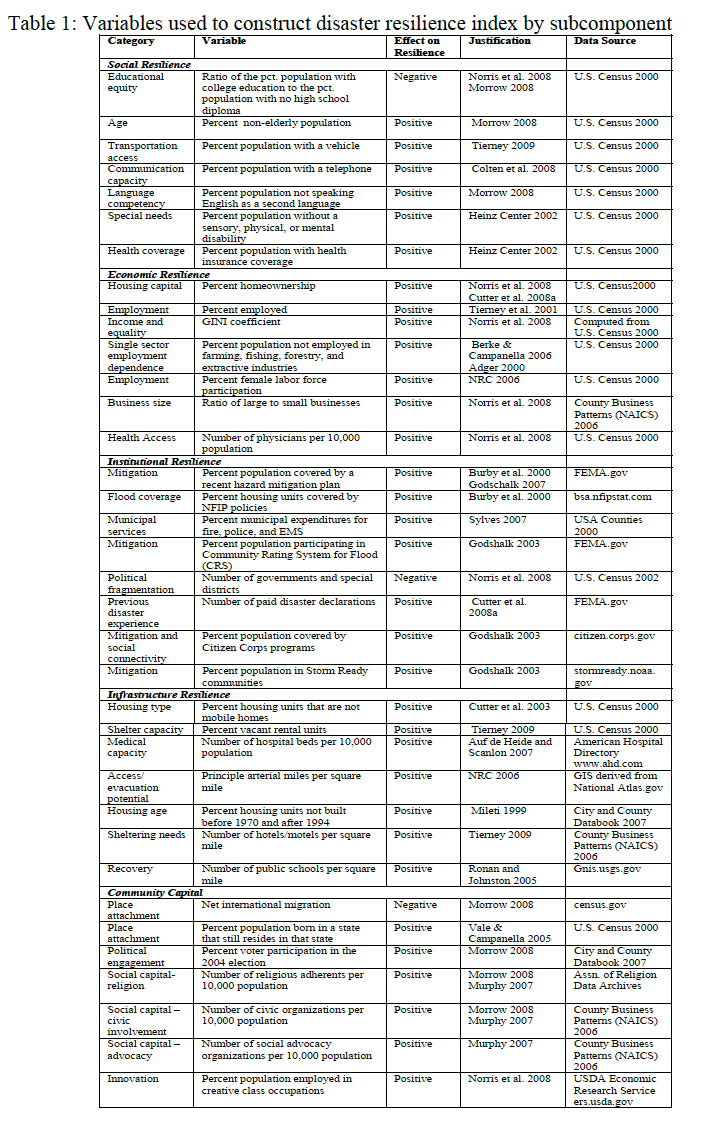

Let's explore our dataset and see how we can map it to the methodology employed by Cutter et al. to calculate the scores for each subcomponent.

To start off small, let's consider the "Social Resilience" subcomponent from table 1. It shows that this subcomponent is comprised of 7 variables:

* educational equity
* age
* transportation access
* communication capacity
* language competency
* special needs
* health coverage

This maps to the 7 aptly named files:

In [16]:
from glob import glob

var_dir = os.path.join("sql", "results")
print("\n".join(glob("{}/*-social-*".format(var_dir))))

sql/results/11-social-educational_equity.csv
sql/results/12-social-age.csv
sql/results/13-social-transportation_access.csv
sql/results/14-social-communication_capacity.csv
sql/results/15-social-language_competency.csv
sql/results/16-social-special_needs.csv
sql/results/17-social-health_coverage.csv


As we saw in the `01-Getting_Started` notebook, each of these files contain records for the measure scored for each county. Let's create a single dataframe that contains resilience scores for each variable pertaining to a subcomponent and the mean score calculated from them:

In [17]:
def get_df(csv_file):
    """Return a dataframe."""
    
    # get dataframe from csv
    df = pd.read_csv(csv_file, skip_blank_lines=True)
    
    # drop rows with NaN
    df = df.dropna()

    # convert fips column from int/float to string and zero fill
    df['fips'] = df['fips'].astype(int).astype(str).str.zfill(5)

    # set fips column as the index so we can join
    df = df.set_index('fips').sort_index()
    
    return df

def add_subcomponent(subcomponent, df):
    """Add scores for variables for a subcomponent."""
    
    # loop over all variables results pertinent to the social subcomponent
    var_names = []
    for csv_file in glob("{}/*-{}-*".format(var_dir, subcomponent)):
        print("doing {}".format(csv_file))
        
        # extract the variable name
        match = re.search(r'-{}-(.+)\.csv'.format(subcomponent), csv_file)
        if not match:
            raise RuntimeError("Failed to extract variable name from {}.".format(csv_file))
        var_name = match.group(1)
        var_names.append(var_name)
        
        # create a dataframe
        df_var = get_df(csv_file)
        
        # get common indexes
        idx = df.index.intersection(df_var.index)
        
        # add variable column
        try:
            df[var_name] = df_var.loc[idx]['measure']
        except:
            display(df_var)
            raise
    
    # create a column that contains the mean for this subcomponent
    df[subcomponent] = df[var_names].mean(axis=1)
    
    return df
    
# calculate social resiliency score
case_study_fips = add_subcomponent("social", case_study_fips) 
display(case_study_fips)

doing sql/results/11-social-educational_equity.csv
doing sql/results/12-social-age.csv
doing sql/results/13-social-transportation_access.csv
doing sql/results/14-social-communication_capacity.csv
doing sql/results/15-social-language_competency.csv
doing sql/results/16-social-special_needs.csv
doing sql/results/17-social-health_coverage.csv


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,educational_equity,age,transportation_access,communication_capacity,language_competency,special_needs,health_coverage,social
fips,,,,,,,,,,,,,,,,,
28033,28,033,00695741,0500000US28033,DeSoto,06,1233556699,53624068,"POLYGON ((-90.31000499999999 34.875097, -90.30...",0.074394,0.840840,0.959084,0.871929,0.945947,0.794331,0.804054,0.755797
45035,45,035,01247998,0500000US45035,Dorchester,06,1484540310,6724254,"POLYGON ((-80.789924 33.179426, -80.790296 33....",0.089060,0.839894,0.939005,0.882391,0.931659,0.765204,0.792519,0.748533
47157,47,157,01639790,0500000US47157,Shelby,06,1977720315,55485268,"POLYGON ((-90.31029799999999 35.004295, -90.30...",0.069148,0.841778,0.881217,0.906074,0.902977,0.755420,0.742001,0.728374
47167,47,167,01639795,0500000US47167,Tipton,06,1187267191,38609225,"(POLYGON ((-90.046598 35.412966, -90.045306 35...",0.038070,0.814857,0.946363,0.905785,0.968961,0.662402,0.779760,0.730885
28137,28,137,00695789,0500000US28137,Tate,06,1048332509,16090912,"POLYGON ((-90.24392399999999 34.60215, -90.241...",0.031925,0.781421,0.920276,0.894385,0.970750,0.631237,0.703891,0.704841
45015,45,015,01247985,0500000US45015,Berkeley,06,2845745102,338007534,"POLYGON ((-80.361301 33.263077, -80.3591 33.27...",0.068516,0.830298,0.941221,0.900311,0.923077,0.726067,0.747420,0.733844
28047,28,047,00695747,0500000US28047,Harrison,06,1486713863,1063618187,"(POLYGON ((-88.871763 30.385659, -88.865652 30...",0.055888,0.808894,0.926019,0.852738,0.928366,0.679323,0.629572,0.697257
28045,28,045,00711756,0500000US28045,Hancock,06,1227560683,204096133,"POLYGON ((-89.68415700000001 30.459152, -89.67...",0.045006,0.724527,0.945355,0.861761,0.951870,0.595020,0.632304,0.679406
47047,47,047,01639742,0500000US47047,Fayette,06,1825375565,3774866,"POLYGON ((-89.643916 35.006373, -89.643772 35....",0.048358,0.700309,0.939360,0.875194,0.968333,0.663527,0.823356,0.716920


Let's compare our results to the baseline:

In [18]:
# create dataframe for comparison; prefix baseline social score with 'baseline'
cmp_df = baseline_df[['county', 'social']].rename(index=str, columns={"social": "baseline_social"})

# add the social score from our dataset
idx = case_study_fips.index.intersection(cmp_df.index)
cmp_df['social'] = case_study_fips.loc[idx]['social']

# add a column showing differences and pct change
cmp_df['change'] = cmp_df['social'] - cmp_df['baseline_social']
cmp_df['pct_change'] = cmp_df['change']/cmp_df['baseline_social']

display(cmp_df)

,county,baseline_social,social,change,pct_change
fips,,,,,
28045,Hancock,0.498,0.679406,0.181406,0.364269
28047,Harrison,0.527,0.697257,0.170257,0.323068
28131,Stone,0.440,0.693471,0.253471,0.576071
45015,Berkeley,0.657,0.733844,0.076844,0.116962
45019,Charleston,0.500,0.738568,0.238568,0.477136
45035,Dorchester,0.743,0.748533,0.005533,0.007447
28033,DeSoto,0.913,0.755797,-0.157203,-0.172183
28093,Marshall,0.356,0.694692,0.338692,0.951382
28137,Tate,0.573,0.704841,0.131841,0.230089


So much for reproducibility. Each county's resiliency score for the social subcomponent differs to a varying degree between the baseline value (from the Cutter study) and our calculated value. However, remember that our baseline data was generated from the original paper which was published in 2010. If you look at the source of our dataset, you'll notice that the records are dated much more recently:

In [19]:
# loop over all variables results pertinent to the social subcomponent
subcomponent = "social"
for csv_file in glob("{}/*-{}-*".format(var_dir, subcomponent)):
    # create a dataframe
    df = get_df(csv_file)
    
    # display the first record of each file
    print("{}:".format(csv_file))
    display(df.head(1))

sql/results/11-social-educational_equity.csv:


,measure,source,date
fips,,,
01001,0.062327,11,1/1/2016


sql/results/12-social-age.csv:


,measure,source,date
fips,,,
01001,0.794446,12,1/1/2016


sql/results/13-social-transportation_access.csv:


,measure,source,date
fips,,,
01001,0.936283,13,1/1/2016


sql/results/14-social-communication_capacity.csv:


,measure,source,date
fips,,,
01001,0.857186,14,2016-01-01


sql/results/15-social-language_competency.csv:


,measure,source,date
fips,,,
01001,0.960386,15,1/1/2016


sql/results/16-social-special_needs.csv:


,measure,source,date
fips,,,
01001,0.568647,16,1/1/2016


sql/results/17-social-health_coverage.csv:


,measure,source,date
fips,,,
01001,0.82926,17,1/1/2016


Note that the date of the first records from each social variable CSV is date 01/01/2016. The Cutter paper's dataset obviously did not contain data from 2011-2016 since it was published in 2010.

Looking back at our comparison of the social scores for each county:

In [20]:
display(cmp_df)

,county,baseline_social,social,change,pct_change
fips,,,,,
28045,Hancock,0.498,0.679406,0.181406,0.364269
28047,Harrison,0.527,0.697257,0.170257,0.323068
28131,Stone,0.440,0.693471,0.253471,0.576071
45015,Berkeley,0.657,0.733844,0.076844,0.116962
45019,Charleston,0.500,0.738568,0.238568,0.477136
45035,Dorchester,0.743,0.748533,0.005533,0.007447
28033,DeSoto,0.913,0.755797,-0.157203,-0.172183
28093,Marshall,0.356,0.694692,0.338692,0.951382
28137,Tate,0.573,0.704841,0.131841,0.230089


We can redirect our attention to the percent change between the baseline and our 2016 data. The most significant changes we see are in the counties of Marshall, which increased its score by 95%, and Tunica, which increased its score by 173%, over the baseline scores in 2010. A quick google search on both of these counties show that they have seen their share of tornado hits in the past and so it seems reasonable that those counties have instituted changes that improved their overall social resilience score.

## Updated Social Resiliency Index

At this point, we continue on with our exercise with full knowledge that we will not be able to reproduce the results from the 2010 paper because of the temporal differences between our data source and the data source used by Cutter et al. However, proceeding with the exercise using our updated data will still prove valuable as a foundation for future data science analysis and machine learning.

Let's proceed with the other subcomponents. For "economic resilience":

In [21]:
subcomponent = "economic"
print("\n".join(glob("{}/*-{}-*".format(var_dir, subcomponent))))
case_study_fips = add_subcomponent(subcomponent, case_study_fips) 
display(case_study_fips)

sql/results/21-economic-housing_capital.csv
sql/results/22-economic-employment.csv
sql/results/23-economic-income_and_equality.csv
sql/results/24-economic-single_sector.csv
sql/results/25-economic-employemnet-female.csv
sql/results/26-economic-business_size.csv
sql/results/27-economic-health_access.csv
doing sql/results/21-economic-housing_capital.csv
doing sql/results/22-economic-employment.csv
doing sql/results/23-economic-income_and_equality.csv
doing sql/results/24-economic-single_sector.csv
doing sql/results/25-economic-employemnet-female.csv
doing sql/results/26-economic-business_size.csv
doing sql/results/27-economic-health_access.csv


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,educational_equity,...,health_coverage,social,housing_capital,employment,income_and_equality,single_sector,employemnet-female,business_size,health_access,economic
fips,,,,,,,,,,,,,,,,,,,,,
28033,28,033,00695741,0500000US28033,DeSoto,06,1233556699,53624068,"POLYGON ((-90.31000499999999 34.875097, -90.30...",0.074394,...,0.804054,0.755797,0.818152,0.543951,0.185943,1.000000,0.731620,0.005692,0.132164,0.488217
45035,45,035,01247998,0500000US45035,Dorchester,06,1484540310,6724254,"POLYGON ((-80.789924 33.179426, -80.790296 33....",0.089060,...,0.792519,0.748533,0.756768,0.500323,0.283005,0.986963,0.646449,0.004684,0.080702,0.465556
47157,47,157,01639790,0500000US47157,Shelby,06,1977720315,55485268,"POLYGON ((-90.31029799999999 35.004295, -90.30...",0.069148,...,0.742001,0.728374,0.571123,0.488421,0.615099,0.999759,0.670620,0.019760,0.231579,0.513766
47167,47,167,01639795,0500000US47167,Tipton,06,1187267191,38609225,"(POLYGON ((-90.046598 35.412966, -90.045306 35...",0.038070,...,0.779760,0.730885,0.759092,0.471479,0.327631,0.997583,0.608558,0.007655,0.072515,0.463502
28137,28,137,00695789,0500000US28137,Tate,06,1048332509,16090912,"POLYGON ((-90.24392399999999 34.60215, -90.241...",0.031925,...,0.703891,0.704841,0.782284,0.397535,0.486426,0.996233,0.499883,0.000000,0.076023,0.462626
45015,45,015,01247985,0500000US45015,Berkeley,06,2845745102,338007534,"POLYGON ((-80.361301 33.263077, -80.3591 33.27...",0.068516,...,0.747420,0.733844,0.747491,0.475789,0.338044,0.998056,0.638651,0.008957,0.067836,0.467832
28047,28,047,00695747,0500000US28047,Harrison,06,1486713863,1063618187,"(POLYGON ((-88.871763 30.385659, -88.865652 30...",0.055888,...,0.629572,0.697257,0.559543,0.432653,0.455932,1.000000,0.600371,0.019120,0.198830,0.466636
28045,28,045,00711756,0500000US28045,Hancock,06,1227560683,204096133,"POLYGON ((-89.68415700000001 30.459152, -89.67...",0.045006,...,0.632304,0.679406,0.682144,0.438571,0.383414,1.000000,0.512348,0.014884,0.072515,0.443411
47047,47,047,01639742,0500000US47047,Fayette,06,1825375565,3774866,"POLYGON ((-89.643916 35.006373, -89.643772 35....",0.048358,...,0.823356,0.716920,0.864832,0.464049,0.460766,0.996045,0.496976,0.000000,0.052632,0.476471


And for "institutional resilience":

In [22]:
subcomponent = "institutional"
print("\n".join(glob("{}/*-{}-*".format(var_dir, subcomponent))))
case_study_fips = add_subcomponent(subcomponent, case_study_fips) 
display(case_study_fips)

sql/results/33-institutional-municipal_services.csv
sql/results/35-institutional-political_fragmentation.csv
doing sql/results/33-institutional-municipal_services.csv
doing sql/results/35-institutional-political_fragmentation.csv


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,educational_equity,...,employment,income_and_equality,single_sector,employemnet-female,business_size,health_access,economic,municipal_services,political_fragmentation,institutional
fips,,,,,,,,,,,,,,,,,,,,,
28033,28,033,00695741,0500000US28033,DeSoto,06,1233556699,53624068,"POLYGON ((-90.31000499999999 34.875097, -90.30...",0.074394,...,0.543951,0.185943,1.000000,0.731620,0.005692,0.132164,0.488217,0.363191,0.980,0.671596
45035,45,035,01247998,0500000US45035,Dorchester,06,1484540310,6724254,"POLYGON ((-80.789924 33.179426, -80.790296 33....",0.089060,...,0.500323,0.283005,0.986963,0.646449,0.004684,0.080702,0.465556,0.318107,0.984,0.651053
47157,47,157,01639790,0500000US47157,Shelby,06,1977720315,55485268,"POLYGON ((-90.31029799999999 35.004295, -90.30...",0.069148,...,0.488421,0.615099,0.999759,0.670620,0.019760,0.231579,0.513766,0.340592,0.980,0.660296
47167,47,167,01639795,0500000US47167,Tipton,06,1187267191,38609225,"(POLYGON ((-90.046598 35.412966, -90.045306 35...",0.038070,...,0.471479,0.327631,0.997583,0.608558,0.007655,0.072515,0.463502,0.113139,1.000,0.556569
28137,28,137,00695789,0500000US28137,Tate,06,1048332509,16090912,"POLYGON ((-90.24392399999999 34.60215, -90.241...",0.031925,...,0.397535,0.486426,0.996233,0.499883,0.000000,0.076023,0.462626,0.148732,0.984,0.566366
45015,45,015,01247985,0500000US45015,Berkeley,06,2845745102,338007534,"POLYGON ((-80.361301 33.263077, -80.3591 33.27...",0.068516,...,0.475789,0.338044,0.998056,0.638651,0.008957,0.067836,0.467832,0.181726,0.984,0.582863
28047,28,047,00695747,0500000US28047,Harrison,06,1486713863,1063618187,"(POLYGON ((-88.871763 30.385659, -88.865652 30...",0.055888,...,0.432653,0.455932,1.000000,0.600371,0.019120,0.198830,0.466636,0.225179,0.944,0.584590
28045,28,045,00711756,0500000US28045,Hancock,06,1227560683,204096133,"POLYGON ((-89.68415700000001 30.459152, -89.67...",0.045006,...,0.438571,0.383414,1.000000,0.512348,0.014884,0.072515,0.443411,0.169226,0.980,0.574613
47047,47,047,01639742,0500000US47047,Fayette,06,1825375565,3774866,"POLYGON ((-89.643916 35.006373, -89.643772 35....",0.048358,...,0.464049,0.460766,0.996045,0.496976,0.000000,0.052632,0.476471,NaN,NaN,NaN


Note that we only have data files for "municipal services" and "political fragmentation" in the "institutional resilience" subcomponent.

For "infrastructure resilience":

In [24]:
subcomponent = "infrastructure"
print("\n".join(glob("{}/*-{}-*".format(var_dir, subcomponent))))
case_study_fips = add_subcomponent(subcomponent, case_study_fips) 
display(case_study_fips)

sql/results/41-infrastructure-housing_type.csv
sql/results/42-infrastructure-shelter_capacity.csv
sql/results/43-infrastructure-medical_capacity.csv
sql/results/43-infrastructure-medical_capacity.csv.new
sql/results/44-infrastructure-access_evacuation_potential.csv
sql/results/45-infrastructure-housing_age.csv
sql/results/46-infrastructure-sheltering_needs.csv
sql/results/47-infrastructure-recovery.csv
doing sql/results/41-infrastructure-housing_type.csv
doing sql/results/42-infrastructure-shelter_capacity.csv
doing sql/results/43-infrastructure-medical_capacity.csv
doing sql/results/43-infrastructure-medical_capacity.csv.new
doing sql/results/44-infrastructure-access_evacuation_potential.csv
doing sql/results/45-infrastructure-housing_age.csv
doing sql/results/46-infrastructure-sheltering_needs.csv
doing sql/results/47-infrastructure-recovery.csv


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,educational_equity,...,political_fragmentation,institutional,housing_type,shelter_capacity,medical_capacity,access_evacuation_potential,housing_age,sheltering_needs,recovery,infrastructure
fips,,,,,,,,,,,,,,,,,,,,,
28033,28,033,00695741,0500000US28033,DeSoto,06,1233556699,53624068,"POLYGON ((-90.31000499999999 34.875097, -90.30...",0.074394,...,0.980,0.671596,0.926510,0.296623,0.000044,0.050518,0.675024,NaN,0.004895,0.279094
45035,45,035,01247998,0500000US45035,Dorchester,06,1484540310,6724254,"POLYGON ((-80.789924 33.179426, -80.790296 33....",0.089060,...,0.984,0.651053,0.779103,0.374668,0.000000,0.046410,0.605732,NaN,NaN,0.300985
47157,47,157,01639790,0500000US47157,Shelby,06,1977720315,55485268,"POLYGON ((-90.31029799999999 35.004295, -90.30...",0.069148,...,0.980,0.660296,0.984007,0.426367,0.000071,0.083935,0.463270,NaN,NaN,0.326287
47167,47,167,01639795,0500000US47167,Tipton,06,1187267191,38609225,"(POLYGON ((-90.046598 35.412966, -90.045306 35...",0.038070,...,1.000,0.556569,0.796866,0.322914,0.000000,0.023338,0.653989,NaN,NaN,0.299518
28137,28,137,00695789,0500000US28137,Tate,06,1048332509,16090912,"POLYGON ((-90.24392399999999 34.60215, -90.241...",0.031925,...,0.984,0.566366,0.655573,0.297612,0.000000,0.028965,0.725800,NaN,NaN,0.284658
45015,45,015,01247985,0500000US45015,Berkeley,06,2845745102,338007534,"POLYGON ((-80.361301 33.263077, -80.3591 33.27...",0.068516,...,0.984,0.582863,0.709085,0.280355,0.000055,0.027563,0.622428,NaN,NaN,0.273257
28047,28,047,00695747,0500000US28047,Harrison,06,1486713863,1063618187,"(POLYGON ((-88.871763 30.385659, -88.865652 30...",0.055888,...,0.944,0.584590,0.862649,0.486575,0.000000,0.053598,0.445354,NaN,0.007460,0.265091
28045,28,045,00711756,0500000US28045,Hancock,06,1227560683,204096133,"POLYGON ((-89.68415700000001 30.459152, -89.67...",0.045006,...,0.980,0.574613,0.799756,0.231983,0.000195,0.037648,0.448510,NaN,0.003264,0.217364
47047,47,047,01639742,0500000US47047,Fayette,06,1825375565,3774866,"POLYGON ((-89.643916 35.006373, -89.643772 35....",0.048358,...,NaN,NaN,0.793784,0.100746,0.000050,0.028310,0.604295,NaN,NaN,0.254539


And finally for "community capital":

In [ ]:
subcomponent = "community_capital"
print("\n".join(glob("{}/*-{}-*".format(var_dir, subcomponent))))
case_study_fips = add_subcomponent(subcomponent, case_study_fips) 
display(case_study_fips)

Now that we've computed the subindex scores for each of the five subcomponents, let's compare them with the baseline scores from the Cutter study:

In [ ]:
cmp_df = None
for cmp in subcomponents:
    # create dataframe for comparison; prefix baseline subindex score with 'baseline'
    if cmp_df is None:
        cmp_df = baseline_df[['county', 'metro_id', 
                              'metro_name', cmp]].rename(index=str,
                                                         columns={cmp: "baseline_{}".format(cmp)})
        idx = case_study_fips.index.intersection(cmp_df.index)
    else:
        idx = case_study_fips.index.intersection(cmp_df.index)
        cmp_df['baseline_{}'.format(cmp)] = baseline_df.loc[idx][cmp]
    
    # add the subindex score from our dataset
    cmp_df[cmp] = case_study_fips.loc[idx][cmp]
    
    # add a column showing differences and pct change
    cmp_df['change_{}'.format(cmp)] = cmp_df[cmp] - cmp_df['baseline_{}'.format(cmp)]
    cmp_df['pct_change_{}'.format(cmp)] = cmp_df['change_{}'.format(cmp)]/cmp_df['baseline_{}'.format(cmp)]

display(cmp_df)

Now let calculate the final composite disaster resilience score for each county and compare our scores with the scores from the Cutter study:

In [ ]:
# aggregate subindex resilience scores
baseline_subcomponents = [ "baseline_{}".format(cmp) for cmp in subcomponents ]
cmp_df['baseline_res_score'] = cmp_df[baseline_subcomponents].sum(axis=1)
cmp_df['res_score'] = cmp_df[subcomponents].sum(axis=1)

# add a column showing differences and pct change
cmp_df['change'] = cmp_df['res_score'] - cmp_df['baseline_res_score']
cmp_df['pct_change'] = cmp_df['change']/cmp_df['baseline_res_score']
display(cmp_df[['county', 'metro_id', 'metro_name', 'baseline_res_score', 'res_score', 'change', 'pct_change']])

Here we note that the county with the largest increase in percent change in its overall resilience index is Tunica, MS with +57.0% while the county with the largest decrease is Fayette, TN with -29.7%.

Finally, we calculate the metro area resilience scores and compare our scores with the Cutter study's:

In [ ]:
# summarize resiliency by metro areas by calculating mean
metro_summary_df = pd.DataFrame(cmp_df.groupby(['metro_id', 'metro_name'])['res_score'].mean(),
                                columns=['res_score'])
metro_summary_df['baseline_res_score'] = cmp_df.groupby(['metro_id', 'metro_name'])['baseline_res_score'].mean()

# add a column showing differences and pct change
metro_summary_df['res_score_change'] = metro_summary_df['res_score'] - metro_summary_df['baseline_res_score']
metro_summary_df['res_score_pct_change'] = metro_summary_df['res_score_change']/metro_summary_df['baseline_res_score']
display(metro_summary_df)

We note that our resilience scores for the three metropolitan areas have decreased in comparison to the scores from the Cutter study though the overall ranking amongst the three areas remain the same.